# MobileNetV2推理与部署

本项目使用[MindSpore Vision](https://mindspore.cn/vision/docs/zh-CN/master/index.html)中的`mobilenet_v2`网络微调的方法来开发一个AI应用，并将训练好的网络模型部署到Android手机上，执行推理和部署功能。同时项目尝试部署Resnet50和VisionTransformer，将实验结果及出现的问题展示在本notebook中。

Gong Cheng, Junwei Han, Xiaoqiang Lu. Remote Sensing Image Scene Classification: Benchmark and State of the Art. Proceedings of the IEEE, 105(10): 1865-1883, 2017.

## 数据准备与加载

首先需要下载本案例所用到的[NWPU-RESISC45数据集](https://gcheng-nwpu.github.io/#Datasets)，该数据集有飞机、机场等45个类别，每个类有大约560张训练图像、140张验证图像。

通过[链接](https://pan.baidu.com/s/1mifR6tU#list/path=%2F)下载数据集并保存至当前路径

数据集的目录结构如下所示：

```txt

datasets
└── NWPU-RESISC45_dataset
    ├──── airplane
    │  ├── airport
    │  ├── baseball_diamond
    │  └── ... ...
        
```

## 数据集划分
下载下来的数据集文件结构不符合模型输入规范，所以需要通过代码对数据集文件进行划分，进行划分后，数据集目录结构如下：

```txt
datasets
└── NWPU-RESISC45_dataset
    ├── infer
    │   ├── airplane.jpg
    │   ├── building.jpg
    │   ├── forest.jpg
    │   └── road.jpg
    ├── train
    │   ├── airplane
    │   ├── airport
    │   ├── baseball_diamond
    │   └── ... ...
    └── val
        ├── airplane
        ├── airport
        ├── baseball_diamond
        └── ... ...
```
具体划分代码如下：

In [ ]:
import os
import shutil
#class_list[]是数据集中分类信息
class_list=['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'church', 'circular_farmland', 'cloud', 'commercial_area', 'dense_residential', 'desert', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'medium_residential', 'mobile_home_park', 'mountain', 'overpass', 'palace', 'parking_lot', 'railway', 'railway_station', 'rectangular_farmland', 'river', 'roundabout', 'runway', 'sea_ice', 'ship', 'snowberg', 'sparse_residential', 'stadium', 'storage_tank', 'tennis_court', 'terrace', 'thermal_power_station', 'wetland']    
#root_path是数据集根目录，img_path是数据集目录下图片路径
root_path='./dataset'
img_path='./dataset/Images/'
train_path='./dataset/train/'
val_path='./dataset/val/'
for cla in class_list:
    os.makedirs(train_path+cla)
    os.makedirs(val_path+cla)
    for root, sub_folders, files in os.walk(img_path+cla):
        for index,name in enumerate(files):
            img_path_=img_path+cla+'/'+name)
            train_path_=train_path+cla+'/'
            val_path_=val_path+cla+'/'
            #按照1:4的比例划分训练集和验证集
            if(index%4):
                shutil.copy(img_path,train_path)
            else:
                shutil.copy(img_path,val_path)

## 数据集加载

In [1]:
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as vision

def create_dataset(path, batch_size=10, train=True, image_size=224):
    dataset = ds.ImageFolderDataset(path, num_parallel_workers=8, class_indexing={'airplane':0, 'airport':1, 'baseball_diamond':2, 'basketball_court':3, 'beach':4, 'bridge':5, 'chaparral':6, 'church':7, 'circular_farmland':8, 'cloud':9, 'commercial_area':10, 'dense_residential':11, 'desert':12, 'forest':13, 'freeway':14, 'golf_course':15, 'ground_track_field':16, 'harbor':17, 'industrial_area':18, 'intersection':19, 'island':20, 'lake':21, 'meadow':22, 'medium_residential':23, 'mobile_home_park':24, 'mountain':25, 'overpass':26, 'palace':27, 'parking_lot':28, 'railway':29, 'railway_station':30, 'rectangular_farmland':31, 'river':32, 'roundabout':33, 'runway':34, 'sea_ice':35, 'ship':36, 'snowberg':37, 'sparse_residential':38, 'stadium':39, 'storage_tank':40, 'tennis_court':41, 'terrace':42, 'thermal_power_station':43, 'wetland':44 })

    # 图像增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if train:
        trans = [
            vision.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    else:
        trans = [
            vision.Decode(),
            vision.Resize(256),
            vision.CenterCrop(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]

    dataset = dataset.map(operations=trans, input_columns="image", num_parallel_workers=8)
    # 设置batch_size的大小，若最后一次抓取的样本数小于batch_size，则丢弃
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

加载训练数据集和验证数据集用于后续的模型训练和验证。

In [2]:
# 加载训练数据集
train_path = "./NWPU-RESISC45_dataset/train"
dataset_train = create_dataset(train_path, train=True)

# 加载验证数据集
val_path = "./NWPU-RESISC45_dataset/val"
dataset_val = create_dataset(val_path, train=False)

## 模型训练

本案例使用预训练模型在NWPU-RESISC45的图像分类数据集上对模型进行微调，并将训练好的CKPT模型文件转换为MINDIR格式，用于后续手机侧的部署。

### MobileNet V2模型原理

MobileNet网络是由Google团队于2017年提出的专注于移动端、嵌入式或IoT设备的轻量级CNN网络，相比于传统的卷积神经网络，MobileNet网络使用深度可分离卷积（Depthwise Separable Convolution）的思想在准确率小幅度降低的前提下，大大减小了模型参数与运算量。并引入宽度系数 $\alpha$ 和分辨率系数 $\beta$ 使模型满足不同应用场景的需求。

由于MobileNet网络中Relu激活函数处理低维特征信息时会存在大量的丢失，所以MobileNetV2网络提出使用倒残差结构（Inverted residual block）和Linear Bottlenecks来设计网络，以提高模型的准确率，且优化后的模型更小。

![mobilenet](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/mobilenet.png)

图中Inverted residual block结构是先使用1x1卷积进行升维，然后使用3x3的DepthWise卷积，最后使用1x1的卷积进行降维，与Residual block结构相反。Residual block是先使用1x1的卷积进行降维，然后使用3x3的卷积，最后使用1x1的卷积进行升维。

> [详细内容可参见MobileNet V2论文](https://arxiv.org/pdf/1801.04381.pdf)

### 下载预训练模型

下载案例所需的[MobileNetV2预训练模型的ckpt文件](https://download.mindspore.cn/vision/classification/mobilenet_v2_1.0_224.ckpt)，预训练模型的宽度系数$\alpha= 1.0$，输入图像大小为(224, 224), 将下载的预训练模型保存在当前目录下。使用MindSpore Vision中的`DownLoad`下载预训练模型文件到当前目录下，示例代码如下所示：

In [6]:
from mindvision.dataset import DownLoad

models_url = "https://download.mindspore.cn/vision/classification/mobilenet_v2_1.0_224.ckpt"

dl = DownLoad()
# 下载预训练模型文件
dl.download_url(models_url)

28716032B [00:40, 717840.02B/s]                                                                                        


### MobileNet V2模型微调

本章使用MobileNet V2的预训练模型进行微调，通过删除MobileNet V2预训练模型中最后一个用于分类的1x1的卷积层的参数，使用狗与牛角包数据集对模型进行重新训练以更新模型参数。

In [3]:
import mindspore.nn as nn
import mindspore as ms

from mindvision.classification.models import mobilenet_v2
from mindvision.engine.loss import CrossEntropySmooth

# 创建模型,其中目标分类数为2，图像输入大小为(224,224)
network = mobilenet_v2(num_classes=45, resize=224)

# 模型参数存入到param_dict
param_dict = ms.load_checkpoint("./mobilenet_v2_1.0_224.ckpt")

# 获取mobilenet_v2网络最后一个卷积层的参数名
filter_list = [x.name for x in network.head.classifier.get_parameters()]

# 删除预训练模型的最后一个卷积层
def filter_ckpt_parameter(origin_dict, param_filter):
    for key in list(origin_dict.keys()):
        for name in param_filter:
            if name in key:
                print("Delete parameter from checkpoint: ", key)
                del origin_dict[key]
                break

filter_ckpt_parameter(param_dict, filter_list)

# 加载预训练模型参数作为网络初始化权重
ms.load_param_into_net(network, param_dict)

# 定义优化器
network_opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9)

# 定义损失函数
network_loss = CrossEntropySmooth(sparse=True, reduction="mean", smooth_factor=0.1, classes_num=45)

# 定义评价指标
metrics = {"Accuracy": nn.Accuracy()}

# 初始化模型
model = ms.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

[WARNING] ME(22960:24276,MainProcess):2022-07-02-20:27:02.800.09 [mindspore\train\serialization.py:645] For 'load_param_into_net', 2 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(22960:24276,MainProcess):2022-07-02-20:27:02.800.09 [mindspore\train\serialization.py:650] head.classifier.weight is not loaded.
[WARNING] ME(22960:24276,MainProcess):2022-07-02-20:27:02.810.05 [mindspore\train\serialization.py:650] head.classifier.bias is not loaded.


Delete parameter from checkpoint:  head.classifier.weight
Delete parameter from checkpoint:  head.classifier.bias
Delete parameter from checkpoint:  moments.head.classifier.weight
Delete parameter from checkpoint:  moments.head.classifier.bias


> 上述WARNING是由于模型微调需要删除预训练模型的最后一个卷积层的参数，所以加载预训练模型会显示`head.classifier`参数未加载，`head.classifier`参数会使用创建模型时的初始化值。

### 模型训练与评估

训练并评估网络，使用MindSpore Vision中的`mindvision.engine.callback.ValAccMonitor`接口打印训练的损失值和评估精度，且在训练完成后，保存评估精度最高的CKPT文件`best.ckpt`在当前目录下。

In [4]:
from mindvision.engine.callback import ValAccMonitor
import mindspore as ms

num_epochs = 6

# 模型训练与验证，训练完成后保存验证精度最高的ckpt文件（best.ckpt）到当前目录下
model.train(num_epochs,
            dataset_train,
            callbacks=[ValAccMonitor(model, dataset_val, num_epochs), ms.train.callback.TimeMonitor()])

--------------------
Epoch: [  1 /   6], Train Loss: [1.372], Accuracy:  0.866
epoch time: 5097072.557 ms, per step time: 2157.948 ms
--------------------
Epoch: [  2 /   6], Train Loss: [1.230], Accuracy:  0.902
epoch time: 5510834.724 ms, per step time: 2333.122 ms
--------------------
Epoch: [  3 /   6], Train Loss: [1.526], Accuracy:  0.910
epoch time: 5705736.730 ms, per step time: 2415.638 ms
--------------------
Epoch: [  4 /   6], Train Loss: [1.406], Accuracy:  0.917
epoch time: 5654768.893 ms, per step time: 2394.060 ms
--------------------
Epoch: [  5 /   6], Train Loss: [1.057], Accuracy:  0.917
epoch time: 5661948.056 ms, per step time: 2397.099 ms
--------------------
Epoch: [  6 /   6], Train Loss: [1.952], Accuracy:  0.929
epoch time: 5626046.180 ms, per step time: 2381.899 ms
End of validation the best Accuracy is:  0.929, save the best ckpt file in ./best.ckpt


### 可视化模型预测

定义 `visualize_model` 函数，使用上述验证精度最高的模型对输入图像进行预测，并将预测结果可视化。

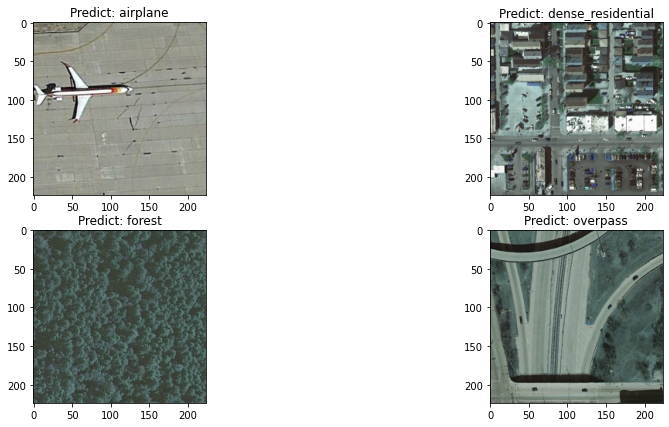

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import mindspore as ms

def visualize_model(path):
    image = Image.open(path).convert("RGB")
    image = image.resize((224, 224))
    plt.imshow(image)

    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)

    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))

    # 扩展数据维数为(1, c, h, w)
    image = np.expand_dims(image, axis=0)

    # 定义并加载网络
    net = mobilenet_v2(num_classes=45, resize=224)
    param_dict = ms.load_checkpoint("./best.ckpt")
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)

    # 模型预测
    pre = model.predict(ms.Tensor(image))
    result = np.argmax(pre)

    class_name = {0:'airplane', 1:'airport', 2:'baseball_diamond', 3:'basketball_court', 4:'beach', 5:'bridge', 6:'chaparral', 7:'church', 8:'circular_farmland', 9:'cloud', 10:'commercial_area', 11:'dense_residential', 12:'desert', 13:'forest', 14:'freeway', 15:'golf_course', 16:'ground_track_field', 17:'harbor', 18:'industrial_area', 19:'intersection', 20:'island', 21:'lake', 22:'meadow', 23:'medium_residential', 24:'mobile_home_park', 25:'mountain', 26:'overpass', 27:'palace' , 28:'parking_lot', 29:'railway', 30:'railway_station', 31:'rectangular_farmland', 32:'river', 33:'roundabout', 34:'runway', 35:'sea_ice', 36:'ship', 37:'snowberg', 38:'sparse_residential', 39:'stadium', 40:'storage_tank', 41:'tennis_court', 42:'terrace', 43:'thermal_power_station', 44:'wetland' }
    plt.title(f"Predict: {class_name[result]}")
    return result

image1 = "./NWPU-RESISC45_dataset/infer/airplane_003.jpg"
plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
visualize_model(image1)

image2 = "./NWPU-RESISC45_dataset/infer/building.jpg"
plt.subplot(2, 2, 2)
visualize_model(image2)

image3 = "./NWPU-RESISC45_dataset/infer/forest.jpg"
plt.subplot(2, 2, 3)
visualize_model(image3)

image4 = "./NWPU-RESISC45_dataset/infer/overpass.jpg"
plt.subplot(2, 2, 4)
visualize_model(image4)

plt.show()

### 模型导出

在模型训练完后，训练完成后的网络模型（即CKPT文件）转换为MindIR格式，用于后续手机侧的推理。通过`export`接口会在当前目录下会生成`mobilenet_v2_1.0_224.mindir`文件。

In [8]:
import mindspore as ms

# 定义并加载网络参数
net = mobilenet_v2(num_classes=45, resize=224)
param_dict = ms.load_checkpoint("best.ckpt")
ms.load_param_into_net(net, param_dict)

# 将模型由ckpt格式导出为MINDIR格式
input_np = np.random.uniform(0.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
ms.export(net, ms.Tensor(input_np), file_name="mobilenet_v2_1.0_224", file_format="MINDIR")

## 手机侧推理与部署

为实现模型文件在手机侧的推理功能，步骤如下：

- 转换文件格式：将MindIR文件格式，转换成Android手机上MindSpore Lite可识别文件；
- 应用部署：在手机侧部署应用APK，即下载一个MindSpore Vision套件Android APK；
- 应用体验：最后将ms模型文件导入到手机侧后，体验狗与牛角包的识别功能。

### 转换文件格式

使用端侧应用的转换工具[MindSpore Lite Converter](https://www.mindspore.cn/lite/docs/zh-CN/master/use/converter_tool.html)，将训练过程当中生成的mobilenet_v2_1.0_224.mindir文件，转换为MindSpore Lite端侧推理框架可识别的文件格式mobilenet_v2_1.0_224.ms文件。

具体的模型文件格式转换方式如下所示：

1. Linux下使用MindSpore Lite Converter转换文件格式，[Linux-x86_64工具下载链接](https://www.mindspore.cn/lite/docs/zh-CN/master/use/downloads.html)。

```shell
# 下载解压后设置软件包的路径，{converter_path}为解压后工具包的路径，PACKAGE_ROOT_PATH为设置的环境变量
export PACKAGE_ROOT_PATH={converter_path}

# 将转换工具需要的动态链接库加入到环境变量LD_LIBRARY_PATH
export LD_LIBRARY_PATH=${PACKAGE_ROOT_PATH}/tools/converter/lib:${LD_LIBRARY_PATH}

# 在mindspore-lite-linux-x64/tools/converter/converter执行转换命令
./converter_lite --fmk=MINDIR --modelFile=mobilenet_v2_1.0_224.mindir  --outputFile=mobilenet_v2_1.0_224
```

2. Windows下使用MindSpore Lite Converter转换文件格式，[Windows-x64工具下载链接](https://www.mindspore.cn/lite/docs/zh-CN/master/use/downloads.html)。

```shell
# 下载解压后设置软件包的路径，{converter_path}为解压后工具包的路径，PACKAGE_ROOT_PATH为设置的环境变量
set PACKAGE_ROOT_PATH={converter_path}

# 将转换工具需要的动态链接库加入到环境变量PATH
set PATH=%PACKAGE_ROOT_PATH%\tools\converter\lib;%PATH%

# 在mindspore-lite-win-x64\tools\converter\converter路径下执行转换命令
call converter_lite --fmk=MINDIR --modelFile=mobilenet_v2_1.0_224.mindir --outputFile=mobilenet_v2_1.0_224
```

转换成功后打印`CONVERT RESULT SUCCESS:0`，且在当前目录下生成`mobilenet_v2_1.0_224.ms`文件。

> 其他环境下载MindSpore Lite Converter参见[下载MindSpore Lite](https://www.mindspore.cn/lite/docs/zh-CN/master/use/downloads.html)。

### 应用部署

下载MindSpore Vision套件的[Android端应用APK](https://download.mindspore.cn/vision/android/mindvision-0.1.0.apk)，或者手机扫描二维码下载。

![qr](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/app_qr_code.png)

并在手机上安装该APK，其应用名称显示为`MindSpore Vision`。

> MindSpore Vision APK主要是作为视觉开发工具的示例所用，提供拍照、选择图片等基础UI功能，并且提供分类、检测等AI应用DEMO。

打开APP后，在首页点击`分类`模块后，即可点击中间按钮进行拍照获取图片，或者点击上侧栏的图像按钮选择进行图片相册用于图像分类功能。

![main](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/app1.png)

在默认情况下，MindSpore Vision`分类`模块内置了一个通用的AI网络模型对图像进行识别分类。

![result](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/source_zh_cn/beginner/images/app2.png)

## 实验结果
| models| Accuracy |
| ----------- | ----------- |
| MobileNet V2      | 92.9%       |
| Resnet50   | 89.4%        |
| VisionTransformer | 78.2% |

## 存在问题及解决方案

### 问题一
原始45类数据集训练得到的Mobilenet V2模型在电脑端能正常推理，并具备较高的准确度。但部署到手机端，出现了严重的分类错误问题，并且测得分类置信度偏低。

![result](./images/result.jpg)

我们猜测原因有二，其一，训练模型从电脑端.mindir文件转换到手机端.ms文件时，为达到轻便性进行压缩，故分类过大时会损失更多数据；其二，置信度和概率值正相关，当分类个数过大，每个类别的预测概率值会整体偏低。我们将数据集减少到10类，手机端的推理回到正常水平。


### 问题二
使用Vision Transformer模型和Resnet50模型进行分类预测并部署到手机端，出现的问题有：分类正确率低，且手机端应用经常出现闪退。

![error](./images/error.gif)

猜测原因：VisT模型和Resnet50模型参数过多，不适合手机端预测

## 收获感想

### 收获

1. 对mindspore平台有了基本了解，对其中的基本模块比如nn.cell有了一定了解，在从pytorch转移到mindspore需要对相关API进行知识上的映射，比如pytorch中forward（）前向传播对应于mindspore中construct()函数；
2. 以前只会downloadzip,不仅耗时长而且没有办法为开源仓做出贡献，现在不仅会gitclone而且还会PR操作，为以后的深入学习打下了一个基础；
3. 对mindspore基础操作有了一定了解和实践，对后续科研和项目开发提供了新的平台和解决方案。

### 感想

1. 有一个完备的中文的官方网站真的让人很幸福，在开发过程中可以随时查文档得到相关参数含义，官方网站提供的案例也非常完备，通过一定学习可以很快完成案例中的网络训练；
2. 讨论是第一生产力，在课堂上的交流讨论使得学习过程不再那么枯燥，也让学习效率有了一个很大的提升，讨论过程中思维的碰撞会激发出无限的可能；
3. 临渊羡鱼不如退而结网，我们下一步方向还是会从底层知识入手学习，逐步深入学习最终能熟练使用mindspore进行项目开发、科学研究。
